In [316]:
#%pip install alpaca-py
#%pip install prophet

In [317]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pandas as pd
import dateutil.parser as datetimeParser
import pickle
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet 

#Set dataset and training parameters 
datasetSize=365 #Set dataset size in days
testSplitSize=50 #Set size of the test split for train and test sets
forecastPeriod=8760 #Set the length of the forecast (in hours)
selectedColumn="high" #Set which price data column to forecast by: open, high, low, close

In [318]:
client = CryptoHistoricalDataClient()

In [319]:
current = datetime.now()
current_date = current.strftime("%Y-%m-%d")
startDate = (current - timedelta(days=datasetSize)).strftime("%Y-%m-%d")
print(current_date)

2024-04-09


In [320]:
# Creating request object
request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD"],
  timeframe=TimeFrame.Day,
  start=startDate,
  end=current_date
)

In [321]:
# Retrieve daily bars for Bitcoin in a DataFrame and printing it
data = client.get_crypto_bars(request_params)

In [322]:
df = data.df

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 365 entries, ('BTC/USD', Timestamp('2023-04-10 05:00:00+0000', tz='UTC')) to ('BTC/USD', Timestamp('2024-04-08 05:00:00+0000', tz='UTC'))
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         365 non-null    float64
 1   high         365 non-null    float64
 2   low          365 non-null    float64
 3   close        365 non-null    float64
 4   volume       365 non-null    float64
 5   trade_count  365 non-null    float64
 6   vwap         365 non-null    float64
dtypes: float64(7)
memory usage: 32.2+ KB


In [324]:
df.head()


open          high           low  \
symbol  timestamp                                                         
BTC/USD 2023-04-10 05:00:00+00:00  28261.60  30442.560000  28155.309378   
        2023-04-11 05:00:00+00:00  30132.76  30566.970000  29810.740000   
        2023-04-12 05:00:00+00:00  29995.67  30500.000000  29698.050000   
        2023-04-13 05:00:00+00:00  30089.14  30931.007398  29844.948363   
        2023-04-14 05:00:00+00:00  30740.07  31049.990000  29989.960000   

                                          close        volume  trade_count  \
symbol  timestamp                                                            
BTC/USD 2023-04-10 05:00:00+00:00  30135.242250  11200.701133     162965.0   
        2023-04-11 05:00:00+00:00  29996.162800   8704.596567     134807.0   
        2023-04-12 05:00:00+00:00  30081.602642   6767.991584     143640.0   
        2023-04-13 05:00:00+00:00  30739.062565   8896.604315     176811.0   
        2023-04-14 05:00:00+00:00  30387.692417   9085.650685     177380.0   

                                           vwap  
symbol  timestamp                                
BTC/USD 2023-04-10 05:00:00+00:00  29309.728415  
        2023-04-11 05:00:00+00:00  30147.945190  
        2023-04-12 05:00:00+00:00  30058.615283  
        2023-04-13 05:00:00+00:00  30437.601831  
        2023-04-14 05:00:00+00:00  30514.500961

In [325]:
# Reset the index of the DataFrame
df.reset_index(inplace=True)

# Select the "timestamp" and "high" columns
df = df[["timestamp", selectedColumn]]

# Remove timezone information from the timestamps in the "ds" column
df['timestamp'] = df['timestamp'].dt.tz_localize(None)

df.head()

,timestamp,high
0,2023-04-10 05:00:00,30442.560000
1,2023-04-11 05:00:00,30566.970000
2,2023-04-12 05:00:00,30500.000000
3,2023-04-13 05:00:00,30931.007398
4,2023-04-14 05:00:00,31049.990000


In [326]:
#Change headers for prophet
df.columns = ['ds','y']

#convert timestamp to correct form
df['ds'] = pd.to_datetime(df['ds'])
df.tail()

,ds,y
360,2024-04-04 05:00:00,69342.960
361,2024-04-05 05:00:00,68622.705
362,2024-04-06 05:00:00,69737.765
363,2024-04-07 05:00:00,70278.119
364,2024-04-08 05:00:00,72707.950


<Axes: xlabel='ds'>

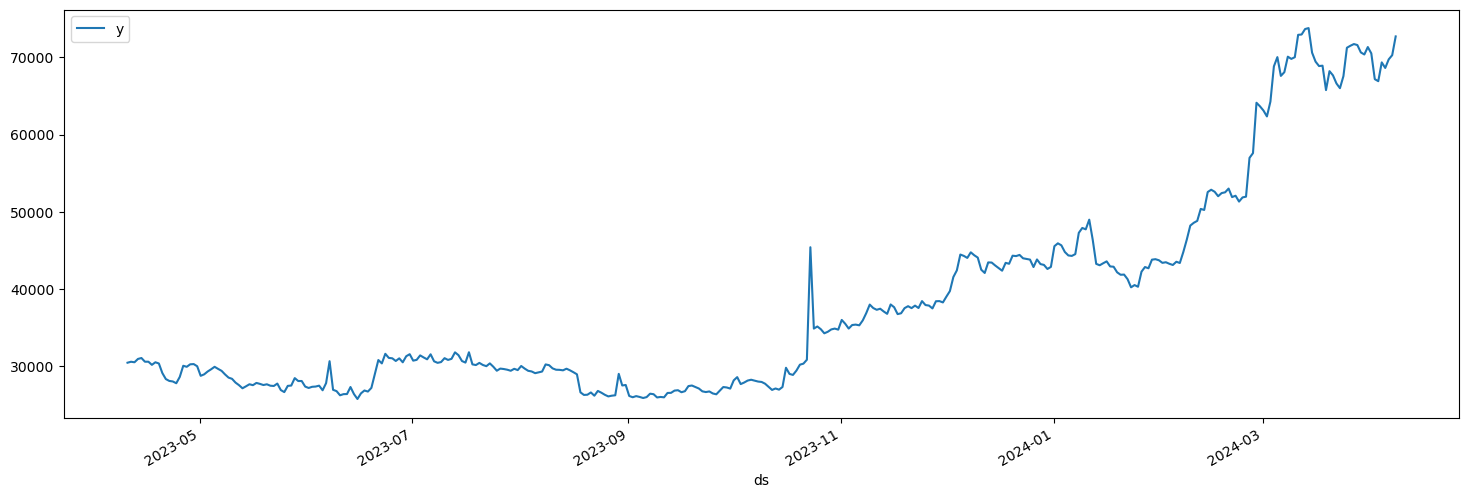

In [327]:
df.plot(x='ds',y='y',figsize=(18,6))

In [328]:
len(df)

365

In [329]:
# Split the dataframe into training and testing sets
train = df.iloc[:len(df)-testSplitSize]
test = df.iloc[len(df)-testSplitSize:]

In [330]:
m = Prophet(interval_width=0.8) #default 80& confidence interval
m.fit(train)
future = m.make_future_dataframe( periods=forecastPeriod, freq='H') #MS for monthly, H for hourly
forecast = m.predict(future)

09:49:27 - cmdstanpy - INFO - Chain [1] start processing
09:49:27 - cmdstanpy - INFO - Chain [1] done processing


In [331]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
9070,2025-02-17 02:00:00,77716.196244,42879.960526,114457.861372,43169.829117,114265.081788,183.687355,183.687355,183.687355,183.687355,183.687355,183.687355,0.0,0.0,0.0,77899.883599
9071,2025-02-17 03:00:00,77719.632027,43705.191756,114888.119301,43170.447412,114271.673908,189.104816,189.104816,189.104816,189.104816,189.104816,189.104816,0.0,0.0,0.0,77908.736844
9072,2025-02-17 04:00:00,77723.067811,42841.115545,114657.599808,43171.065707,114278.266028,192.695446,192.695446,192.695446,192.695446,192.695446,192.695446,0.0,0.0,0.0,77915.763257
9073,2025-02-17 05:00:00,77726.503594,43102.056551,114446.575345,43171.684003,114284.858147,194.503547,194.503547,194.503547,194.503547,194.503547,194.503547,0.0,0.0,0.0,77921.007140
9074,2025-02-17 06:00:00,77729.939377,43658.392864,114332.435048,43172.302298,114291.450267,194.591918,194.591918,194.591918,194.591918,194.591918,194.591918,0.0,0.0,0.0,77924.531295


In [332]:
test.tail()

,ds,y
360,2024-04-04 05:00:00,69342.960
361,2024-04-05 05:00:00,68622.705
362,2024-04-06 05:00:00,69737.765
363,2024-04-07 05:00:00,70278.119
364,2024-04-08 05:00:00,72707.950


In [333]:
plot_plotly(m ,forecast)

In [334]:
plot_components_plotly(m, forecast)

In [335]:
from statsmodels.tools.eval_measures import rmse

In [336]:
predictions = forecast.iloc[-testSplitSize:]['yhat']

In [337]:

print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions,test['y']))
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Squared Error between actual and  predicted values:  13066.099657281882
Mean Value of Test Dataset: 66153.97678057932
